# Comparing 21cmFAST with 21cmEMU directly

In this tutorial, we will use 21cmFAST to simulate a lightcone and compare it with the output from 21cmEMU. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

#import py21cmfast as p21c

from py21cmemu import Emulator

from py21cmemu.properties import emulator_properties

In [171]:
p21c.__version__

'3.3.1.dev6+g95523bc'

In [2]:
properties = emulator_properties()
limits = properties.limits
USER_PARAMS = properties.user_params
COSMO_PARAMS = properties.cosmo_params
FLAG_OPTIONS = properties.flag_options

We'll start by generating a 21cmFAST lightcone. For the astro parameters, let's take a parameter set from the test set of the emulator.

In [3]:
with np.load('Test_data_sample.npz') as f:
    idx = 10
    test_param = f['X_test'][idx]
    test_param *= properties.limits[:, 1] - properties.limits[:, 0]
    test_param += properties.limits[:, 0]
    test_param[7] *= 1000.
    test_db_ps = f['PS'][idx] # in log
    test_db_ps = 10**test_db_ps
keys = ['F_STAR10', 'ALPHA_STAR', 'F_ESC10', 'ALPHA_ESC', 'M_TURN', 't_STAR', 'L_X','NU_X_THRESH', 'X_RAY_SPEC_INDEX']

input_dict = {k:v for k, v in zip(keys, test_param)}
input_dict

{'F_STAR10': -1.0125570000000002,
 'ALPHA_STAR': 0.4673339999999999,
 'F_ESC10': -1.650905,
 'ALPHA_ESC': 0.3960569999999999,
 'M_TURN': 8.776446,
 't_STAR': 0.844543,
 'L_X': 40.395174,
 'NU_X_THRESH': 1050.086911,
 'X_RAY_SPEC_INDEX': 1.5971830000000002}

In [4]:
ap = p21c.AstroParams(input_dict)

In [206]:
lightcone = p21c.run_lightcone(
    redshift = 5.0,
    max_redshift = 35.0,
    astro_params = ap,
    user_params =USER_PARAMS,
    lightcone_quantities=("brightness_temp", "density"),
    global_quantities=("brightness_temp", 'density', 'xH_box'),
    flag_options = FLAG_OPTIONS,
    cosmo_params = COSMO_PARAMS,
    direc='_cache'
)

We'll save the lightcone so that we don't need to re-run it later.
You can skip this step if you don't want to save it.

In [207]:
np.savez('lightcone_example', redshifts = lightcone.node_redshifts,
                      xHI = lightcone.global_xHI,
                      global_Tb = lightcone.global_brightness_temp,
                      Tb = lightcone.brightness_temp,
                      zs = lightcone.lightcone_redshifts,
                      pars = input_dict
                      )

In [4]:
lightcone = np.load('lightcone_example.npz')

In [7]:
emu = Emulator()

In [8]:
theta, emu_out, errs = emu.predict(input_dict)

In [9]:
zs = emu_out.redshifts
xHI = emu_out.xHI
Tb = emu_out.Tb
PS = emu_out.PS
PS_k = emu_out.PS_ks
PS_z = emu_out.PS_redshifts

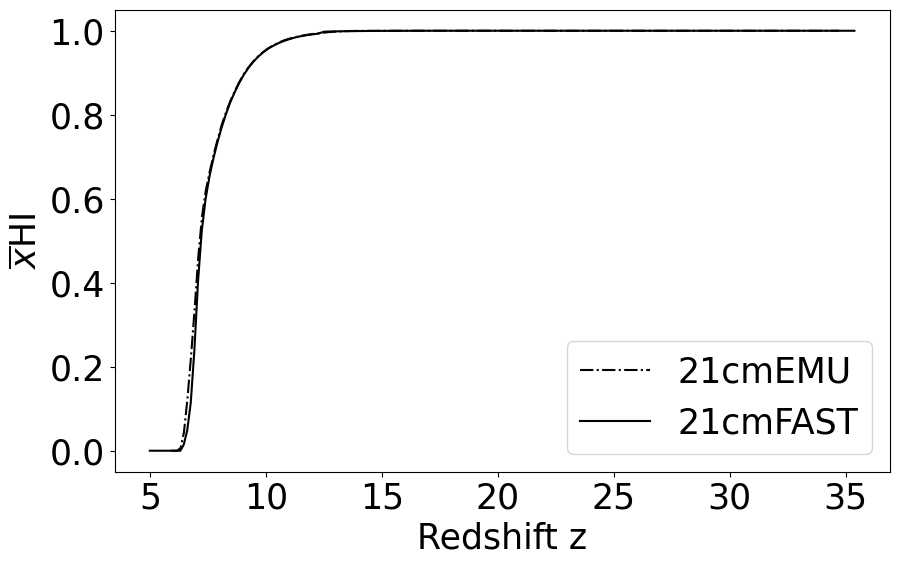

In [10]:
plt.figure(figsize = (10,6))
fs = 25
plt.plot(zs, xHI, ls = '-.', color = 'k', label = '21cmEMU')
#plt.plot(lightcone.node_redshifts, lightcone.global_xHI, color = 'k', label = '21cmFAST')
plt.plot(lightcone['redshifts'], lightcone['xHI'], color = 'k', label = '21cmFAST')

plt.legend(fontsize = fs)
plt.xticks(fontsize = fs)
plt.yticks(fontsize = fs)
plt.ylabel(r'$\overline{x}$HI', fontsize = fs)
plt.xlabel(r'Redshift z', fontsize = fs)
plt.show()

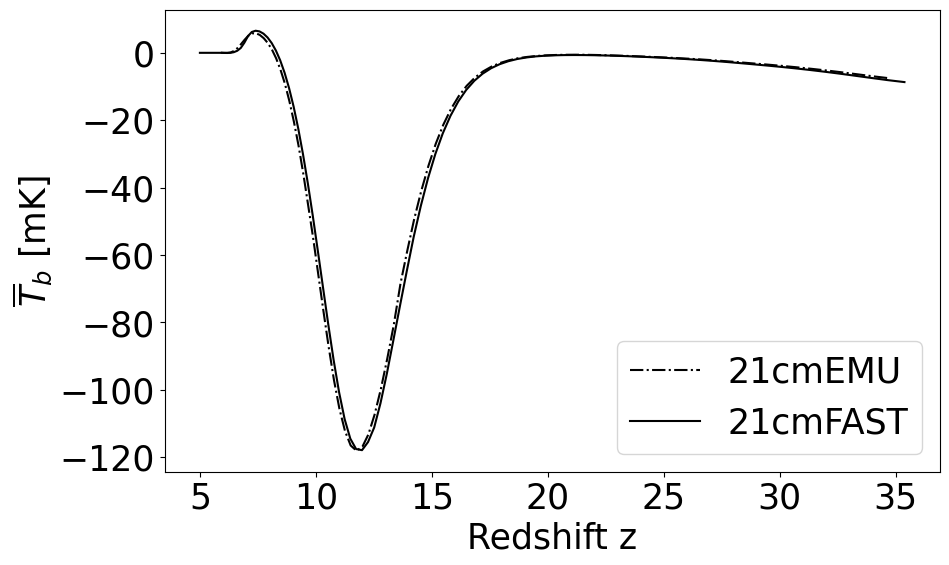

In [11]:
# Directly compare Tb from test set and Tb predicted by emulator
N = 7
cs = ['k','r','lime','b', 'orange', 'cyan', 'magenta', 'coral']
plt.figure(figsize = (10,6))

plt.plot(zs, Tb, ls = '-.', color = 'k', label = '21cmEMU')
#plt.plot(lightcone.node_redshifts, lightcone.global_brightness_temp, color = 'k', label = '21cmFAST')
plt.plot(lightcone['redshifts'], lightcone['global_Tb'], color = 'k', label = '21cmFAST')
plt.legend(fontsize = fs)
plt.xticks(fontsize = fs)
plt.yticks(fontsize = fs)
plt.ylabel(r'$\overline{T}_b$ [mK]', fontsize = fs)
plt.xlabel(r'Redshift z', fontsize = fs)
plt.show()

The 21-cm power spectrum database that the emulator was trained on is made from coeval cubes rather than lightcones.\
To obtain a result as close as possible to the database, we therefore run coeval cubes. 

In [ ]:
coeval7, coeval8, coeval9, coeval10, coeval15 = p21c.run_coeval(
    redshift = [7.0, 8.0, 9.0, 10.0, 15.0],
    user_params = user_params,
    cosmo_params = cosmo_params,
    astro_params = ap,
    flag_options = flag_options,
    random_seed = 42,
)

In [ ]:
for i,box in zip([7,8,9,10,15],[coeval7, coeval8, coeval9, coeval10, coeval15]):
    np.savez('coeval'+i, redshift = box.redshift,
                          xHI = box.xHI,
                          global_Tb = box.brightness_temp_struct.global_Tb,
                          Tb = box.brightness_temp,
                          astro_params = box.astro_params,
                          user_params = box.user_params,
                          flag_options = box.flag_options,
                          cosmo_params = box.cosmo_params,
                          random_seed = box.random_seed
                          )

We use `powerbox` to calculate the 21-cm PS from the coeval box.

In [52]:
from powerbox.tools import get_power

In [ ]:
ps_coeval = calculate_ps(lightcone['Tb'], lightcone['zs'], USER_PARAMS['BOX_LEN'], 
                      calc_1d=True, calc_2d=False, 
                      zs=properties.PS_zs,
                      nbins_1d = properties.PS_ks,
                      bin_ave=True,
                      interp=None,
                      k_weights=ignore_zero_absk,
                      )

We can also calculate the PS from the lightcone just to compare them. To do this, we use the `py21cmFAST-tools` package that wraps around `powerbox`.

In [ ]:
from py21cmfast_tools import calculate_ps
from powerbox.tools import ignore_zero_absk

In [ ]:
ps_lc = calculate_ps(lightcone['Tb'], lightcone['zs'], USER_PARAMS['BOX_LEN'], 
                      calc_1d=True, calc_2d=False, 
                      zs=properties.PS_zs,
                      nbins_1d = properties.PS_ks,
                      bin_ave=True,
                      interp=None,
                      k_weights=ignore_zero_absk,
                      )

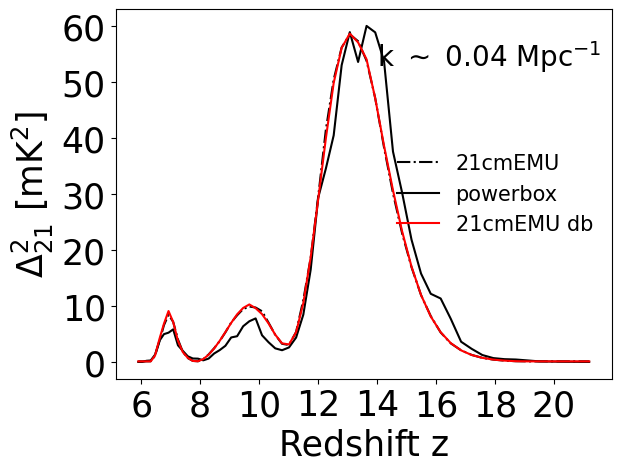

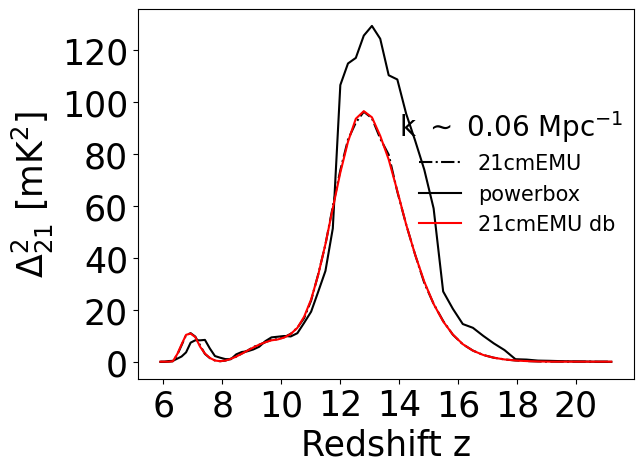

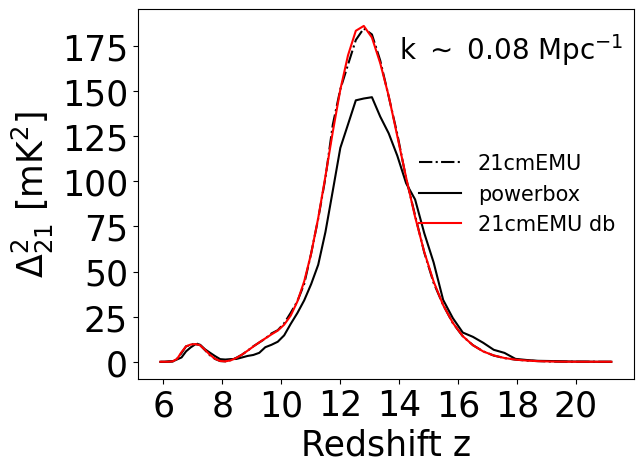

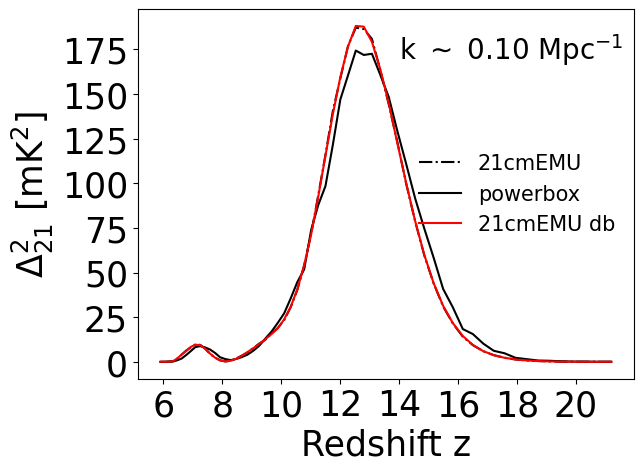

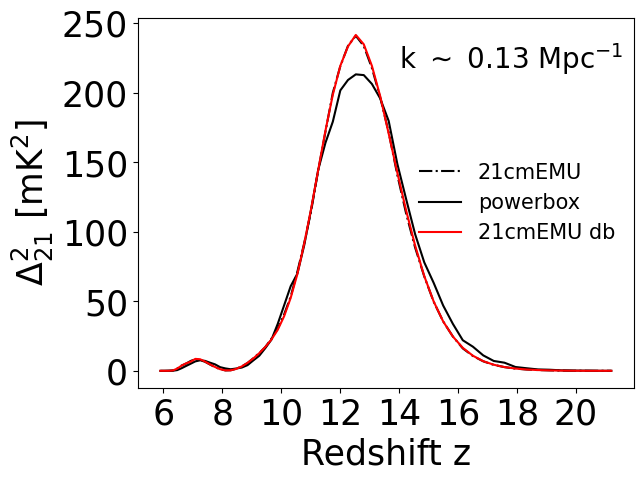

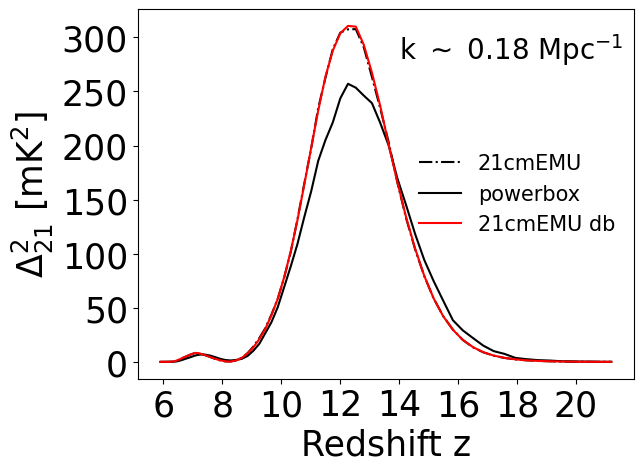

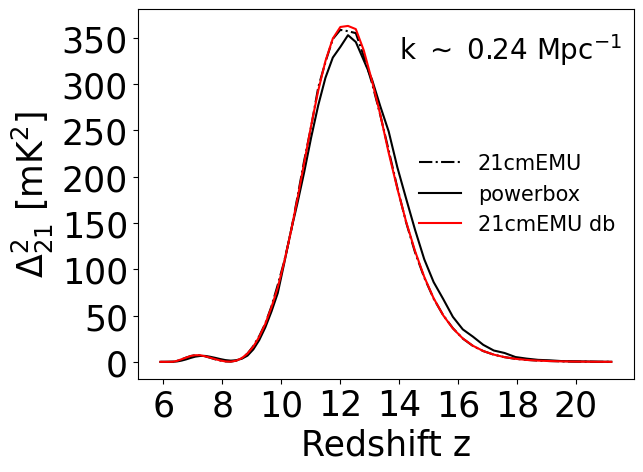

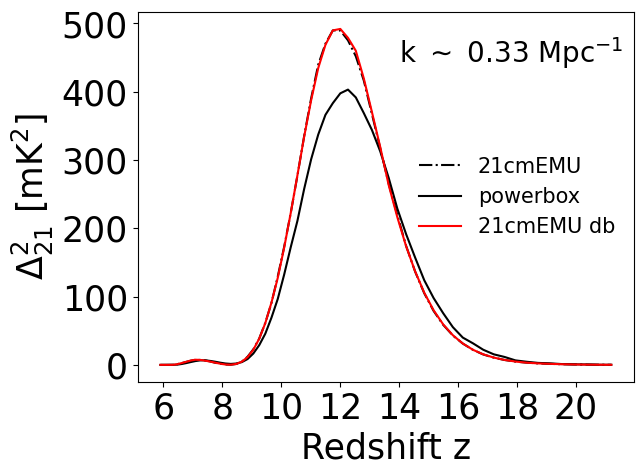

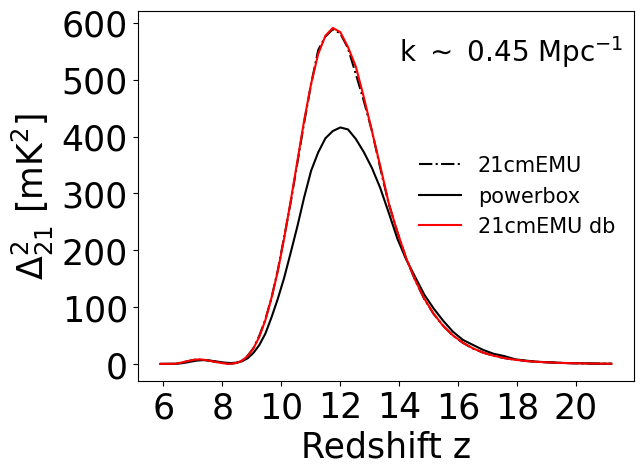

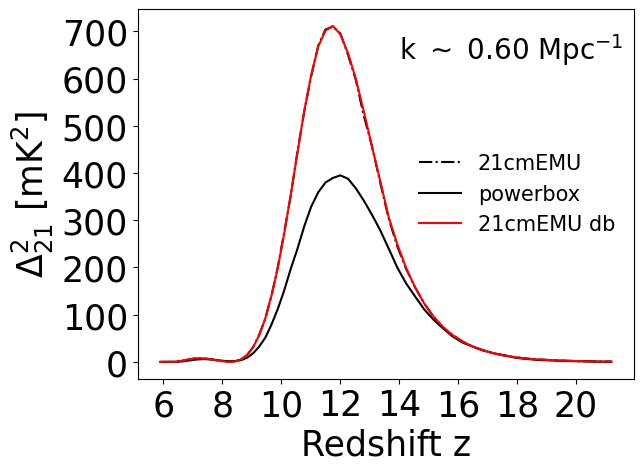

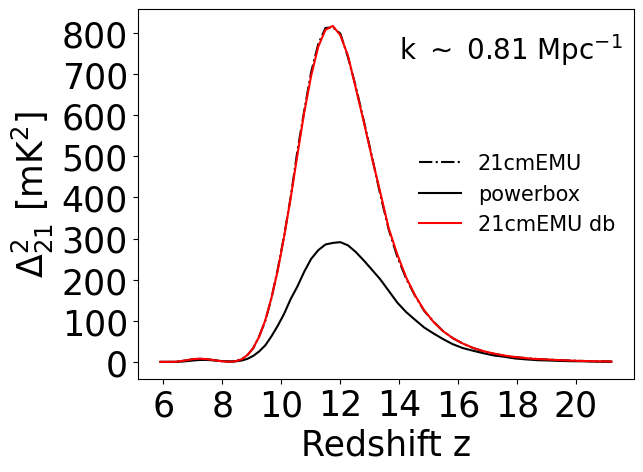

In [38]:
# Directly compare Tb from test set and Tb predicted by emulator
for kbin in range(11):
    df = PS_k**3/(2*np.pi**2)
    plt.plot(PS_z, PS[:,kbin], ls = '-.', color = 'k', label = '21cmEMU')
    plt.plot(PS_z, (ps_lc['ps_1D'])[:,kbin], color = 'k', label = 'powerbox')
    plt.plot(PS_z, test_db_ps[:,kbin], color = 'r', label = '21cmEMU db')
    plt.text(14, np.nanmax(test_db_ps[:,kbin])*0.9, r'k $\sim$ %.2f Mpc$^{-1}$'%PS_k[kbin], fontsize = fs-5)
    plt.legend(fontsize = fs-10, loc = 'center right', frameon=False)
    plt.xticks(fontsize = fs)
    plt.yticks(fontsize = fs)
    plt.ylabel(r'$\Delta^2_{21}$ [mK$^2$]', fontsize = fs)
    plt.xlabel(r'Redshift z', fontsize = fs)
    plt.show()

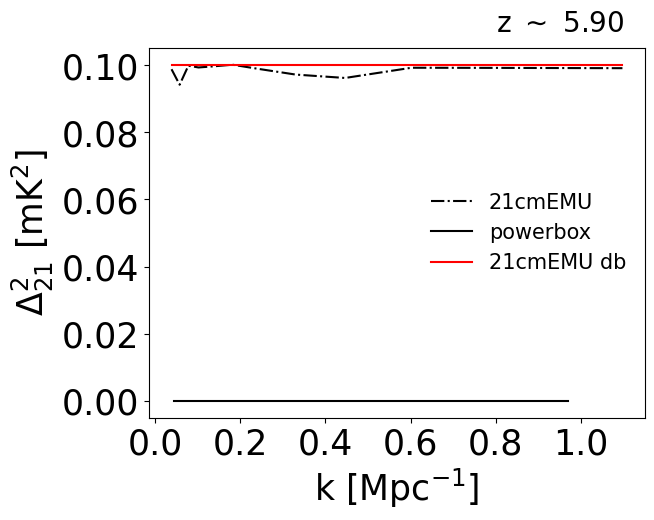

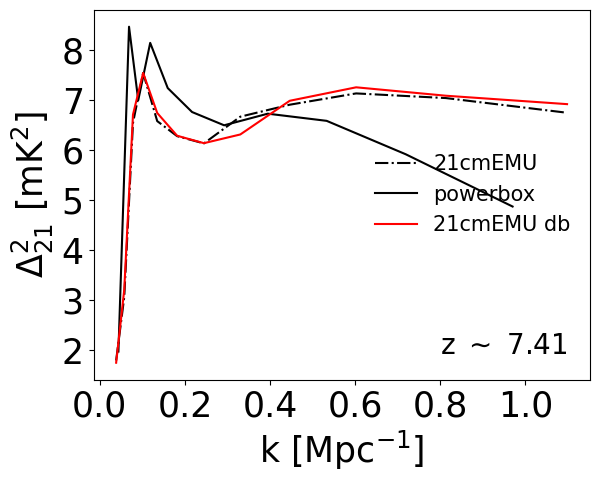

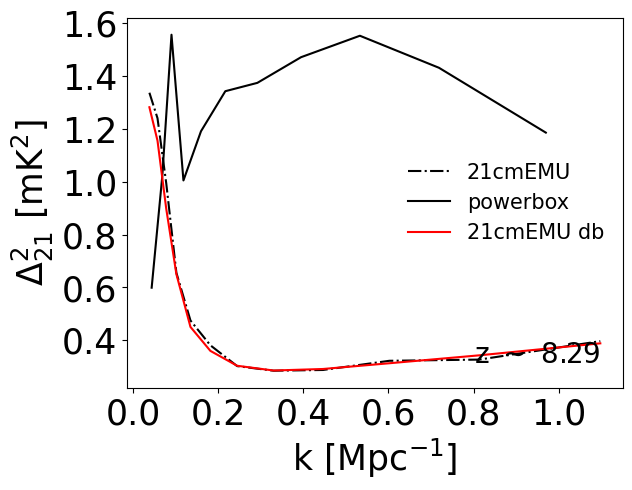

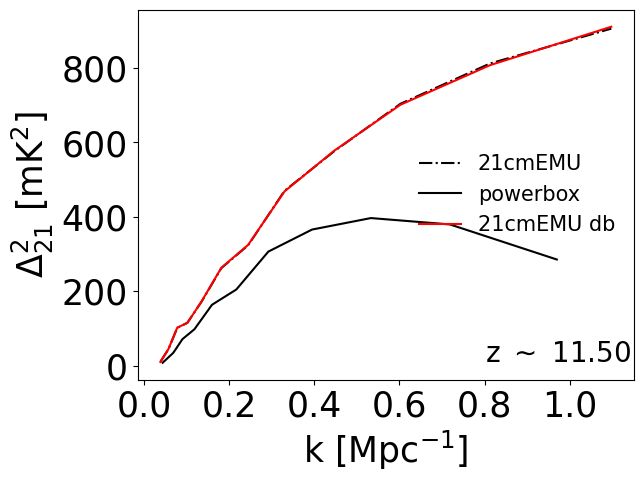

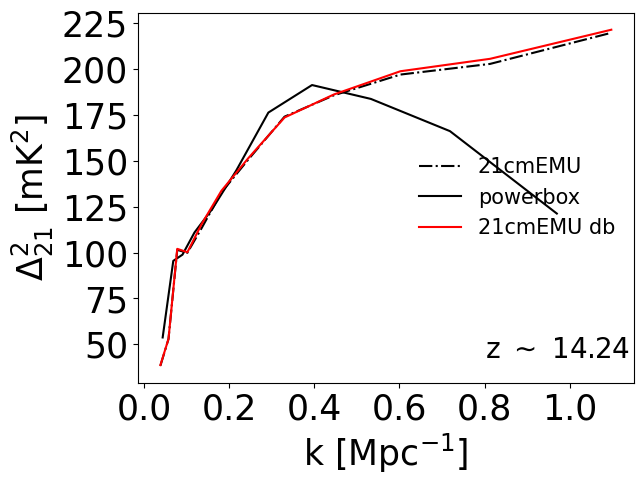

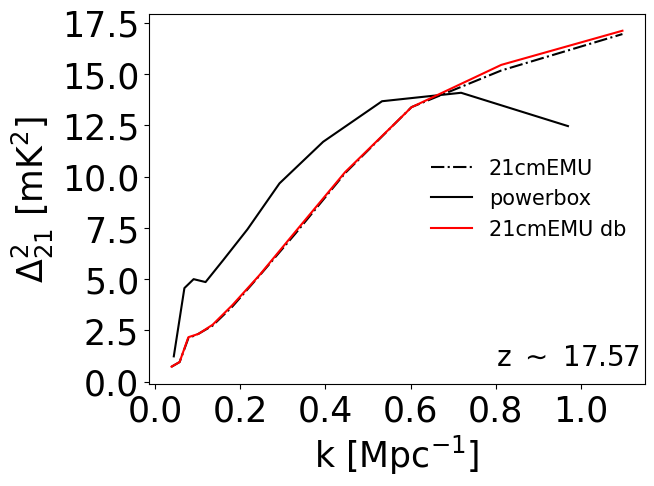

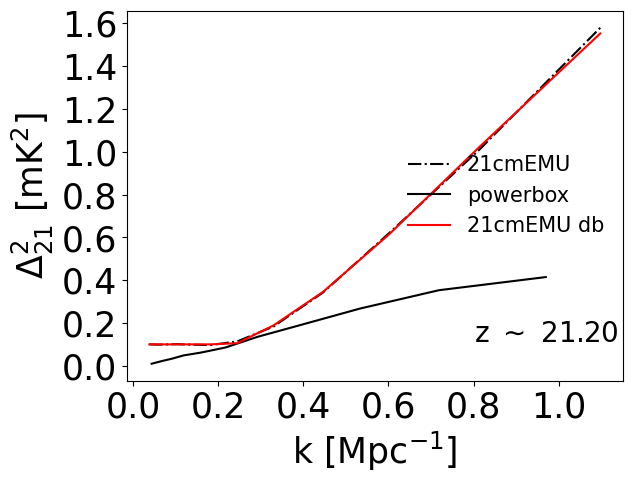

In [51]:
# Directly compare Tb from test set and Tb predicted by emulator
for zbin in [0,10,15,30,40,50,59]:
    df = PS_k**3/(2*np.pi**2)
    plt.plot(PS_k, PS[zbin], ls = '-.', color = 'k', label = '21cmEMU')
    plt.plot(ps_lc['k'], (ps_lc['ps_1D'])[zbin], color = 'k', label = 'powerbox')
    plt.plot(PS_k, test_db_ps[zbin], color = 'r', label = '21cmEMU db')
    plt.text(0.8, np.nanmin(test_db_ps[zbin])*1.1, r'z $\sim$ %.2f '%PS_z[zbin], fontsize = fs-5)
    plt.legend(fontsize = fs-10, loc = 'center right', frameon=False)
    plt.xticks(fontsize = fs)
    plt.yticks(fontsize = fs)
    plt.ylabel(r'$\Delta^2_{21}$ [mK$^2$]', fontsize = fs)
    plt.xlabel(r'k [Mpc$^{-1}$]', fontsize = fs)
    plt.show()